# Invisible Light - plotting a galaxy's colours

In this notebook, you will be able to use data from the LOFAR deep fields release to choose a galaxy and plot its _spectral energy distribution_ (SED)- that is, how bright the galaxy is across the electromagnetic spectrum. This data is from a well-studied field called the Lockman Hole, which is a patch of sky located in the constellation of Ursa Major. 

First we will import the Python libraries that we will use in this exercise:


In [1]:
from astropy.io import fits              # astropy is a library of helpful tools for astronomy
from astropy import units as u           # for example, units helps us keep track of astronomical units in calculations
from astropy.coordinates import SkyCoord # ...and SkyCoord can do transformations with astronomical coordinates
import matplotlib.pyplot as plt          # matplotlib is library for plotting 
from scipy.interpolate import interp1d   # scipy has useful maths tools, such as this curve fitting tool
import numpy as np                       # numpy is for storing & manipulating data in arrays

Then we will import the data files. All of the data is publicly available on the LOFAR surveys website, but the data files are very large (> 1 GB!) and take a long time to load, so we're using a short version of the table that I put together for my research. In astronomy, data is often stored in a file format called "fits" and one way to access it is to use the Astropy libary we imported above, which has a "fits" function to open such files.


In [2]:
data_file = fits.open("https://star.herts.ac.uk/~joanna/LOFAR_galaxies.fits")

table = data_file[1].data
headers = data_file[1].header.keys

# Now we have two variables:
# - table, which contains all of the table data
# - header, which just contains the information in the table header i.e. the names of the columns

This data file is a table of data, with fluxes at several different wavelengths across the electromagnetic spectrum, from low frequency radio in LOFAR all the way through to optical and UV. If you print the variable "headers", you can see the names of all of the columns in the table. Some of these are a bit cryptic! They will be explained later.


In [4]:
print(headers)

<bound method Header.keys of XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  782 / length of dimension 1                          
NAXIS2  =                   50 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                  148 / number of table fields                         
EXTNAME = 'Tile_386876_9_SPIRE_cat.fits'                                        
TUCD1   = 'ID      '                                                            
TUCD2   = 'pos.eq.RA'                                                           
TUCD3   = 'pos.eq.DEC'                                                          

Each row of the table is a different galaxy, and you can find its position on the sky by looking at the right ascension (RA) and declination (Dec) in the table, which are given with the keys 'RA' and 'DEC'.

Look up the coordinates of some of the galaxies in the table in [Aladin](https://aladin.u-strasbg.fr/AladinLite/)  - this tool shows sky surveys at multiple wavelengths, so you can see what your galaxy looks like across the spectrum.




In [5]:
n = 2 # n will be the number of the row in the table. You can change n to select any row.

#~~~~~~~~~~~~~~~~~~~~~~~~
# Let's define a galaxy as one single row of this table
#Python starts counting at 0, so we subtract 1 from n
#~~~~~~~~~~~~~~~~~~~~~~~~
galaxy = table[n-1]

#~~~~~~~~~~~~~~~~~~~~~~~~
# Then we can print the coordinates of the galaxy you've chosen!
#~~~~~~~~~~~~~~~~~~~~~~~~
RA = galaxy['RA']
Dec = galaxy['DEC']
coords = SkyCoord(RA*u.degree, Dec*u.degree)

print(f"Coordinates of galaxy {n}: {coords.ra.hms[0]:0.0f} {coords.ra.hms[1]:0.0f} {coords.ra.hms[2]:0.2f}, \
 +{coords.dec.dms[0]:0.0f} {coords.dec.dms[1]:0.0f} {coords.dec.dms[2]:0.2f}")

# The long line of code above is just to nicely format our coordinates


Coordinates of galaxy 2: 10 49 51.17,  +56 16 32.73


Here is a table that shows the different "bands" of the observations, the name of the column with the data for that band in the table, the units for the data in that column, and the wavelength that the band corresponds to.


<!-- "ugriz" is short for U-band, G-band, R-band, I-band, and Z-band, detailed on [the Wikipedia article on photometric systems](https://en.wikipedia.org/wiki/Photometric_system): -->
$$\begin{array}{|c|c|c|}
\hline \text{Band}                  & \text{Table key}        & \text{Units}       & \text{Wavelength}(\lambda)\\
\hline \text{u}                     & \text{'u_flux'}         & \text{microJy}     & \text{365 nm}\\
\hline \text{g}                     & \text{'g_flux'}         & \text{microJy}     & \text{475 nm}\\
\hline \text{r}                     & \text{'r_flux'}         & \text{microJy}     & \text{658 nm}\\
\hline \text{i}                     & \text{'i_rcs_flux'}     & \text{microJy}     & \text{806 nm}\\
\hline \text{z}                     & \text{'z_flux'}         & \text{microJy}     & \text{900 nm}\\
\hline \text{J}                     & \text{'J_flux'}         & \text{microJy}     & \text{1.24}\mu\text{m} \\
\hline \text{K}                     & \text{'K_flux'}         & \text{microJy}     & \text{2.19}\mu\text{m} \\
\hline \text{SWIRE channel 1}       & \text{'ch1_swire_flux'} & \text{microJy}     & \text{3.6}\mu\text{m} \\
\hline \text{SWIRE channel 2}       & \text{'ch2_swire_flux'} & \text{microJy}     & \text{4.5}\mu\text{m} \\
\hline \text{SWIRE channel 3}       & \text{'ch3_swire_flux'} & \text{microJy}     & \text{5.8}\mu\text{m} \\
\hline \text{SWIRE channel 4}       & \text{'ch4_swire_flux'} & \text{microJy}     & \text{8}\mu\text{m} \\
\hline \text{Spitzer MIPS}          & \text{'F_MIPS_24'}      & \text{microJy}     & \text{24}\mu\text{m} \\
\hline \text{Herschel PACS band 1}  & \text{'F_PACS_100'}     & \text{mJy}         & \text{100}\mu\text{m} \\
\hline \text{Herschel PACS band 2}  & \text{'F_PACS_160'}     & \text{mJy}         & \text{160}\mu\text{m} \\
\hline \text{Herschel Spire band 1} & \text{'F_SPIRE_250'}    & \text{mJy}         & \text{250}\mu\text{m} \\
\hline \text{Herschel Spire band 2} & \text{'F_SPIRE_350'}    & \text{mJy}         & \text{350}\mu\text{m} \\
\hline \text{Herschel Spire band 3} & \text{'F_SPIRE_500'}    & \text{mJy}         & \text{500}\mu\text{m} \\
\hline
\end{array}$$

\*note that the last few rows are measured in frequency, not wavelength! This is standard in radio astronomy, and since we are combining data from a number of different sources, we have to deal with this and convert everything into either wavelength or frequency.

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Fluxes is a list that contains all of the keys to the table for the fluxes we want:
#~~~~~~~~~~~~~~~~~~~~~~~~
fluxes = ['u_flux','g_flux','r_flux','i_rcs_flux','z_flux','J_flux','K_flux', 'ch1_swire_flux', 'ch2_swire_flux',\
          'ch3_swire_flux','ch4_swire_flux','F_MIPS_24','F_PACS_100','F_PACS_160', 'F_SPIRE_250','F_SPIRE_350',\
          'F_SPIRE_500']

#~~~~~~~~~~~~~~~~~~~~~~~~
# Flux scale is a list of the factors by which we have to multiply the fluxes to convert them to mJy
#~~~~~~~~~~~~~~~~~~~~~~~~
flux_scale = [1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1,1,1,1,1]

# flux_scale = np.ones(len(fluxes))


#~~~~~~~~~~~~~~~~~~~~~~~~
# Wavelengths is a list of all of the wavelengths of the data in metres, excepte the radio data
#~~~~~~~~~~~~~~~~~~~~~~~~
wavelengths = [365e-9,475e-9,658e-9,806e-9,900e-9,1.24e-6,2.19e-6,3.6e-6,4.5e-6,5.8e-6,8e-6,24e-6,100e-6,
              160e-6,250e-6,350e-6,500e-6]


#~~~~~~~~~~~~~~~~~~~~~~~~
# Frequencies contains the frequencies of the radio data, which we convert to wavelength and add to the end 
# of the wavelengths list:
# #~~~~~~~~~~~~~~~~~~~~~~~~
# frequencies = [1.4e9,610e6,324e6,150e6]
# radio_wlens = [3e8/nu for nu in frequencies]
# wavelengths = wavelengths + radio_wlens


#~~~~~~~~~~~~~~~~~~~~~~~~
# SED is a list that contains the fluxes scaled to be in mJy
#~~~~~~~~~~~~~~~~~~~~~~~~
SED = np.array([galaxy[flux]*scale for flux,scale in zip(fluxes, flux_scale)])/np.array(wavelengths)

print(SED)
print([galaxy[flux] for flux in fluxes])


NameError: name 'galaxy' is not defined

Now plot the SED: wavelength on the x-axis, and flux on the y-axis. You might find it helpful to plot it on a log scale. Can you plot or fit a line between the points to show the shape of the SED more clearly

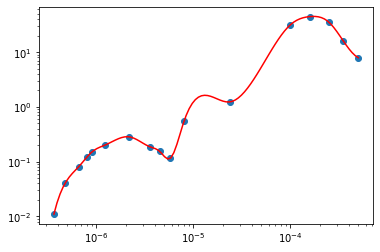

In [7]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# We'll use the scipy interp1d function to plot a curve between the points.
#~~~~~~~~~~~~~~~~~~~~~~~~
fit = interp1d(np.log10(wavelengths), np.log10(SED), fill_value='extrapolate', kind="cubic")
x = np.logspace(np.log10(wavelengths[0]), np.log10(wavelengths[-1]), 100)

#~~~~~~~~~~~~~~~~~~~~~~~~
# Now we make the plot using matplotlib subplots:
#~~~~~~~~~~~~~~~~~~~~~~~~
fix, ax = plt.subplots()
ax.scatter(wavelengths, SED)
plt.plot(x, 10**fit(np.log10(x)), color="red")
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()


Compare the shape of the SED of this galaxy to some typical SEDs of different types of galaxies below. What type of galaxy do you think this is? Are there any other ways we could confirm that?

![text](typical_SEDs.jpg)